# Experiment
This section introduces a small-scale experiment to test the viability of the main ideas in the proposed modeling framework for evaluating human-AI collaborative decision-making.

## Some basic configuration parameters

In [ ]:
SEED=115          #Random seed for reproducible results
HIST_PER_SALES=36 #Number of historical months to forecast one month into the future (due to seasonality, 3 years used)
HIST_PER_RET=1    #For returns, just one period is used 
                  #as the sales of the previous month across customer categories determines the returns for the following month

DODIFF=False      #1° differencing to remove trend (not done as the RNN model performs bettter with out it)
DOWRITE=False     #Write predictions to a CSV file

In [ ]:
"""
Install James Houghton's PySD library (Houghton and Siegel, 2015) that allows integration of Python
(therefore, data science routines) into system dynamics models.
"""
pysd_instd = !pip list -v | grep pysd
if len(pysd_instd) == 0:
  !pip install pysd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 4.9 MB/s 
     |████████████████████████████████| 48 kB 5.9 MB/s 
     |████████████████████████████████| 1.4 MB 47.4 MB/s 
     |████████████████████████████████| 96 kB 5.7 MB/s 
     |████████████████████████████████| 843 kB 48.4 MB/s 
  Created wheel for parsimonious: filename=parsimonious-0.9.0-py3-none-any.whl size=44314 sha256=3cf9411f94275dec616b10c893b054c0b11840f46ea32cdc89167a8bc5a2b8e1
  Stored in directory: /root/.cache/pip/wheels/a4/54/88/c1ee7de0eabd1fb817cbf35824e4c2cba664d5816ddc64efb1
Successfully built parsimonious
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

## **Step 1**: 
Read sales data file into a string, split into lines, and strip off empty lines

In [ ]:
from google import colab
colab.drive.mount("/gdrive")

Mounted at /gdrive


In [76]:
import os
fname = os.path.join \
("/gdrive/MyDrive/Colab Notebooks/IJPE Model/Demand_Returns_Online_vSeasTrend_N1905_DESSim_v8_CoV0.075.csv")

with open(fname) as fil:
  data = fil.read()

lines = data.split("\n")[1:]
print("Data type, length, 1st 3 rows in lines: ", type(lines), len(lines), lines[0:3])

Data type, length, 1st 3 rows in lines:  <class 'list'> 481 ['01/06/1981,25,10,6,9,0', '01/07/1981,21,8,10,3,9', '01/08/1981,15,6,7,2,6']


In [ ]:
def strip_empty_lines(lines):
  lines_stripped = [line for _, line in enumerate(lines) if len(line) != 0]
  return lines_stripped

lines = strip_empty_lines(lines)

## **Step 2**: 
Generate months covariate, add to sales features

In [ ]:
from datetime import datetime
import numpy as np

In [ ]:
#0-hot coding for months
months_coding = np.identity(12)

months = [(datetime.strptime(str.split(",")[0], "%d/%m/%Y")).month  for _, str in enumerate(lines)]

months_feature = np.zeros((len(lines),12))
for i in range(len(months_feature)):
  months_feature[i] = months_coding[months[i] - 1]

print(months_feature[0:8], months_feature.shape)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] (480, 12)


## **Step 3**: 
Read sales, returns data intp numpy arrays

In [ ]:
#initialize array to store historical sales data as forecast input
sales_raw = np.zeros((len(lines),))

#initialize array to store returns' features and returns
num_ret_features = 4 #sales by customer category (A,B,C) and returns

ret_features = np.zeros((len(lines), num_ret_features))
ret_raw = np.zeros((len(lines),))

print(sales_raw.shape, ret_features.shape, ret_raw.shape)

(480,) (480, 4) (480,)


In [ ]:
for i, line in enumerate(lines):
  sales_raw[i] = float(line.split(",")[1])
  ret_raw[i] = float(line.split(",")[-1])
  ret_features[i] = [float(x) for x in line.split(",")[2:]]
  
print("1st five: sales, ret_features, ret ", sales_raw[0:5], ret_features[0:5], ret_raw[0:5])

1st five: sales, ret_features, ret  [25. 21. 15. 18. 17.] [[10.  6.  9.  0.]
 [ 8. 10.  3.  9.]
 [ 6.  7.  2.  6.]
 [ 8.  7.  3.  4.]
 [ 7.  5.  5.  5.]] [0. 9. 6. 4. 5.]


## **Step 4 (optional)**: 
Apply 1° differencing to detrend sales, returns

In [ ]:
if DODIFF:
  sales = sales_raw[1:] - sales_raw[:-1]
  ret = ret_raw[1:] - ret_raw[:-1]
  ret_features = ret_features[1:] - ret_features[:-1]

  months_feature = months_feature[1:]
  years_since_sin = years_since_sin[1:]
  years_since_cos = years_since_cos[1:]
else:
  sales = sales_raw
  ret = ret_raw

In [ ]:
def dediff(ser: np.ndarray, sertype: int = 0, dstype: int = 0) -> np.ndarray:
  ser_dd = ser.copy()
  
  #sertype = 0: sales; 1: returns
  #dstype = 0: train; 1: val; 2: test
  ds = sales_raw if sertype == 0 else ret_raw
  seq_len = HIST_PER_SALES if sertype == 0 else HIST_PER_RET

  init = ds[seq_len - 1]

  if dstype != 0:
    init = ds[train_samples + seq_len - 1] if dstype == 1 \
    else ds[train_samples + val_samples + seq_len - 1]
  
  for i in range(ser_dd.shape[0]):
    if i == 0:
      ser_dd[i] += init 
    else:
      ser_dd[i] += ser_dd[i-1]
  
  return ser_dd

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(y=sales, name="Sales"),
                go.Scatter(y=ret, name="Returns")]
)
fig.show()

## **Step 5**: 
Determine training, validation, and test sample sizes

In [ ]:
train_samples = int(0.6 * len(sales))
val_samples = int(0.1 * len(sales))
test_samples = len(sales) - train_samples - val_samples

assert(train_samples + val_samples + test_samples == len(sales))
print("Train, val, test sample sizes: ", train_samples, val_samples, test_samples)

Train, val, test sample sizes:  288 48 144


## **Step 6**: 
Normalize all data; concatenate months covariate to normalized sales data to complete the sales features' dataset

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler((-1, 1))

sales_norm = np.reshape(sales, (sales.shape[0], 1))
ret_norm = np.reshape(ret, (ret.shape[0], 1))

sales_norm = mmscaler.fit_transform(sales_norm)
ret_norm = mmscaler.transform(ret_norm)

mmscaler2 = MinMaxScaler((-1, 1))
ret_features_norm = mmscaler2.fit_transform(ret_features)

In [ ]:
#Concatenate months coding to sales_norm for a total of 12+1 features
sales_features = np.concatenate((months_feature, sales_norm), axis=1)
print(sales_features.shape)

(480, 13)


## **Step 7**: 
Generate datasets from timeseries arrays

In [ ]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(SEED)
tf.random.set_seed(SEED)

#For sales forecasting

sequence_length_sales = HIST_PER_SALES
batch_size_sales = 36

"""
Generate sequences as a result of a sliding window of length "sequence_length".

Example:
data = [0 1 2 3 4 5 6] + sequence_length = 3 -> [0 1 2], [1 2 3], [2 3 4], [3 4 5], and [4 5 6].

The first entry of the target sequence specifies the desired target for the first sequence. 

"""

train_sales = keras.utils.timeseries_dataset_from_array (
    data=sales_features[:-1], 
    targets=sales_norm[sequence_length_sales:],
    sequence_length=sequence_length_sales,
    batch_size=batch_size_sales,
    shuffle=False,
    start_index=0,
    end_index=train_samples
)

val_sales = keras.utils.timeseries_dataset_from_array(
    data=sales_features[:-1], 
    targets=sales_norm[sequence_length_sales:],
    sequence_length=sequence_length_sales,
    batch_size=batch_size_sales,
    shuffle=False,
    start_index=train_samples,
    end_index=train_samples + val_samples
)

test_sales = keras.utils.timeseries_dataset_from_array (
    data=sales_features[:-1], 
    targets=sales_norm[sequence_length_sales:],
    sequence_length=sequence_length_sales,
    batch_size=1,
    shuffle=False,
    start_index=train_samples + val_samples
)

In [ ]:
#For returns forecasting
np.random.seed(SEED)
tf.random.set_seed(SEED)

sequence_length_ret = HIST_PER_RET
batch_size_ret = 36

train_ret = keras.utils.timeseries_dataset_from_array (
    data=ret_features_norm[:-1], 
    targets=ret_norm[sequence_length_ret:],
    sequence_length=sequence_length_ret,
    batch_size=batch_size_ret,
    shuffle=False,
    start_index=0,
    end_index=train_samples
)

val_ret = keras.utils.timeseries_dataset_from_array(
    data=ret_features_norm[:-1], 
    targets=ret_norm[sequence_length_ret:],
    sequence_length=sequence_length_ret,
    batch_size=batch_size_ret,
    shuffle=False,
    start_index=train_samples,
    end_index=train_samples + val_samples
)

test_ret = keras.utils.timeseries_dataset_from_array (
    data=ret_features_norm[:-1], 
    targets=ret_norm[sequence_length_ret:],
    sequence_length=sequence_length_ret,
    batch_size=1,
    shuffle=False,
    start_index=train_samples + val_samples
)

## **Step 8**: 
Generate DNN forecast (sales) and evaluate

In [ ]:
from tensorflow.keras import layers

np.random.seed(SEED)
tf.random.set_seed(SEED)

inputs = keras.Input(shape=(sequence_length_sales, sales_features.shape[-1]))

x = layers.LSTM(225, recurrent_dropout=0.1)(inputs) 
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1)(x)

model_sales = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("sales_dnn.keras", save_best_only=True)]
model_sales.compile(optimizer="adam", loss="mse", metrics=["mse"])

history_sales = model_sales.fit(x=train_sales, 
                                validation_data=val_sales,   
                                epochs=150, 
                                shuffle=False,
                                callbacks=callbacks)

Epoch 1/150
8/8 [==============================] - 4s 142ms/step - loss: 0.1558 - mse: 0.1558 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 2/150
8/8 [==============================] - 1s 92ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 3/150
8/8 [==============================] - 1s 90ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 4/150
8/8 [==============================] - 1s 93ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 5/150
8/8 [==============================] - 1s 90ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 6/150
8/8 [==============================] - 1s 88ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 7/150
8/8 [==============================] - 1s 92ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 8/150
8/8 [==============================] - 1s 97ms/step - loss: 0.0037 - mse: 0.0

In [ ]:
model = keras.models.load_model("sales_dnn.keras")
print(f"Test MSE: {model.evaluate(test_sales)[1]:.3f}")

108/108 [==============================] - 1s 7ms/step - loss: 0.0020 - mse: 0.0020
Test MSE: 0.002


## **Step 9**: 
Generate plot for predictions on sales test data; write predictions to a csv file

In [ ]:
y_sales_preds = model_sales.predict(test_sales)
y_sales_preds = mmscaler.inverse_transform(y_sales_preds)

In [ ]:
test_start_idx = train_samples + val_samples + HIST_PER_SALES
y_sales_actual = sales_raw[test_start_idx:test_start_idx + len(y_sales_preds)]

In [ ]:
if DODIFF:
  y_sales_preds[:, 0] = dediff(y_sales_preds[:, 0], 0, 2)

In [ ]:
plot_data = [go.Scatter(y=y_sales_actual, name="Actual sales"),
             go.Scatter(y=y_sales_preds[:,0], name="Forecasted sales")]
fig = go.Figure(data=plot_data, layout_title_text="Sales forecast")
fig.show()

In [ ]:
from datetime import date

suffix = date.today().strftime("%Y%m%d")
op = "/gdrive/MyDrive/Colab Notebooks/Tinkering/Sales_Preds_"+suffix+".csv"

#Write sales predictions
if DOWRITE:

  fname = os.path.join(op)
  print(fname)

  f = open(fname, "w")

  out = list()
  out = [str(f) for f in y_sales_preds[-96:, 0]]

  file_out = '\n'.join(map(str, out))
  f.write(file_out)
  f.close()

## **Step 10**: 
Generate DNN forecast (returns) and evaluate

In [ ]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Returns FC model
inputs = keras.Input(shape=(sequence_length_ret, ret_features.shape[-1]))

x = layers.GRU(150, recurrent_dropout=0.1)(inputs) 
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1)(x)

model_ret = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("returns_dnn.keras", save_best_only=True)]
model_ret.compile(optimizer="adam", loss="mse", metrics=["mse"])

history_ret = model_ret.fit(train_ret, 
                            validation_data=val_ret, 
                            epochs=150, 
                            shuffle=False,
                            callbacks=callbacks)

Epoch 1/150
8/8 [==============================] - 3s 67ms/step - loss: 1.1579 - mse: 1.1579 - val_loss: 0.7626 - val_mse: 0.7626
Epoch 2/150
8/8 [==============================] - 0s 19ms/step - loss: 0.7714 - mse: 0.7714 - val_loss: 0.6167 - val_mse: 0.6167
Epoch 3/150
8/8 [==============================] - 0s 19ms/step - loss: 0.4750 - mse: 0.4750 - val_loss: 0.4808 - val_mse: 0.4808
Epoch 4/150
8/8 [==============================] - 0s 21ms/step - loss: 0.2506 - mse: 0.2506 - val_loss: 0.3596 - val_mse: 0.3596
Epoch 5/150
8/8 [==============================] - 0s 21ms/step - loss: 0.1089 - mse: 0.1089 - val_loss: 0.2612 - val_mse: 0.2612
Epoch 6/150
8/8 [==============================] - 0s 21ms/step - loss: 0.0487 - mse: 0.0487 - val_loss: 0.1925 - val_mse: 0.1925
Epoch 7/150
8/8 [==============================] - 0s 23ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.1524 - val_mse: 0.1524
Epoch 8/150
8/8 [==============================] - 0s 22ms/step - loss: 0.0452 - mse: 0.04

In [ ]:
model = keras.models.load_model("returns_dnn.keras")
print(f"Test MSE: {model.evaluate(test_ret)[1]:.3f}")

143/143 [==============================] - 1s 2ms/step - loss: 8.2380e-04 - mse: 8.2380e-04
Test MSE: 0.001


## **Step 12**: 
Generate plot for predictions on returns test data; write predictions to a csv file

In [ ]:
y_ret_preds = model_ret.predict(test_ret)

y_ret_preds = mmscaler.inverse_transform(y_ret_preds)

In [ ]:
test_start_idx = train_samples + val_samples + sequence_length_ret
y_ret_actual = ret[test_start_idx:test_start_idx + len(y_ret_preds)]

In [ ]:
#Returns predictions plot
plot_data = [go.Scatter(y=y_ret_actual, name="Actual returns"),
             go.Scatter(y=y_ret_preds[:,0], name="Forecasted returns")]
fig = go.Figure(data=plot_data, layout_title_text="Returns forecast")
fig.show()

In [ ]:
op = "/gdrive/MyDrive/Colab Notebooks/Tinkering/Returns_Preds_"+suffix+".csv"

#Write returns predictions
if DOWRITE:

  fname = os.path.join(op)

  f = open(fname, "w")

  out = list()
  out = [str(f) for f in y_ret_preds[-96:, 0]]

  file_out = '\n'.join(map(str, out))
  f.write(file_out)
  f.close()

## **Step 11**: 
Plot losses

In [ ]:
#Plot train, validation losses: sales
loss_sales = history_sales.history["mse"]
val_loss_sales = history_sales.history["val_mse"]

loss_ret = history_ret.history["mse"]
val_loss_ret = history_ret.history["val_mse"]


from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2, 
                    shared_xaxes=True, shared_yaxes=True, 
                    x_title="Epochs", y_title="Mean Squared Error loss",
                    subplot_titles=("Losses: <b>Sales</b> model", "Losses: <b>Returns</b> model"),
                    horizontal_spacing=0.06)

fig.layout.annotations[0]["font"] = {"size":16}
fig.layout.annotations[1]["font"] = {"size":16}

fig.layout.annotations[2]["font"] = {"size":12} #since axis is shared
fig.layout.annotations[3]["font"] = {"size":12}

fig.add_trace(go.Scatter(y=loss_sales[:], name="Training loss", line_color="grey", line_dash="dashdot"),
              row=1, col=1)
fig.add_trace(go.Scatter(y=val_loss_sales[:], name="Validation loss", line_color="orange"),
              row=1, col=1)

fig.add_trace(go.Scatter(y=loss_ret[:], name="Training loss", line_color="grey", line_dash="dashdot", showlegend=False),
              row=1, col=2)
fig.add_trace(go.Scatter(y=val_loss_ret[:], name="Validation loss", line_color="orange", showlegend=False),
              row=1, col=2)

fig.update_yaxes(range=[0, 0.1])

fig.update_layout(template="ggplot2")
fig.update_layout(font_color="black") #default color; exceptions specified explicitly
fig.update_layout(title={'xanchor':'center'}, title_font={'size':18})

fig.show()

##**Step 12**: 
Compare forecast performance between heuristic and DNN approaches in the system dynamics model 

In [ ]:
def skip_n(iter, n):
  for i in range(n):
    next(iter)

def next_test_input(iter):
  N, _ = next(iter)
  assert(N.shape[0] == 1)
  return N

In [ ]:
s_test_iter = iter(test_sales)
r_test_iter = iter(test_ret)

skip_n(s_test_iter, 12) #From 108, retain 96 (ignore 12)
skip_n(r_test_iter, 47) #From 143, retain 96 (ignore 47)

In [ ]:
def reinitialize_predictions():
  s_test_iter = iter(test_sales)
  r_test_iter = iter(test_ret)
  skip_n(s_test_iter, 12) #From 108, retain 96 (ignore 12)
  skip_n(r_test_iter, 47) #From 143, retain 96 (ignore 47)
  return s_test_iter, r_test_iter

In [ ]:
import pysd
sd_path = "/gdrive/MyDrive/Colab Notebooks/IJPE Model/IJPE_SD_FC Sector Heuristics vs DNN_20220811.mdl"
model = pysd.read_vensim(sd_path)

In [ ]:
s_test_iter, r_test_iter = reinitialize_predictions()

In [ ]:
def dnn_sales_predict() -> float:
  S = next_test_input(s_test_iter)
  
  pred = model_sales.predict(S)
  pred = mmscaler.inverse_transform(pred)

  s_curr_pred = np.round(pred[0, 0], 2)
  
  return s_curr_pred

In [ ]:
def dnn_returns_predict() -> float:
  R = next_test_input(r_test_iter)
  
  pred = model_ret.predict(R)
  pred = mmscaler.inverse_transform(pred)
  
  r_curr_pred = np.round(pred[0, 0], 2)

  return r_curr_pred

In [ ]:
model.components.dnn_sales_predictions = dnn_sales_predict
model.components.dnn_returns_predictions = dnn_returns_predict

In [ ]:
result = model.run(return_columns=['Perception of sales', 'Perception of returns', \
                          'DNN sales predictions', 'DNN returns predictions', \
                          'Order timeseries', 'Returns timeseries'])
result.head()

,Perception of sales,Perception of returns,DNN sales predictions,DNN returns predictions,Order timeseries,Returns timeseries
1,70.000000,19.670000,69.500000,20.639999,70.0,21.0
2,70.000000,20.113333,66.269997,21.709999,67.0,22.0
3,69.000000,20.742222,62.939999,20.709999,62.0,23.0
4,66.666667,21.494815,62.540001,18.219999,62.0,18.0
5,65.111111,20.329877,64.050003,17.889999,59.0,18.0


In [ ]:
from plotly.colors import n_colors

def gen_fccomp_graph(result, title, orders_col, heur_col, rnn_col, show_title=False):
  greys_dark = n_colors('rgb(0, 0, 0)', 'rgb(200, 200, 200)', 4, colortype='rgb')
  
  ordcol_id, ordcol_name = orders_col
  heurcol_id, heurcol_name = heur_col
  rnncol_id, rnncol_name = rnn_col

  fig = go.Figure();
  
  fig.add_trace(go.Scatter(y=result[ordcol_id], name=ordcol_name, 
                         line_color=greys_dark[2], line_dash="dashdot"))
  fig.add_trace(go.Scatter(y=result[heurcol_id], name=heurcol_name,
                         line_color=greys_dark[0], line_dash="dot"))
  fig.add_trace(go.Scatter(y=result[rnncol_id], name=rnncol_name,
                         line_color="orange"))

  fig.update_xaxes(title_text="Time (Months)", title_font=dict(size=12))
  fig.update_yaxes(title_text="Units/Month", title_font=dict(size=12))

  if show_title==True:
    fig.update_layout(height=500, title_text=title)
    fig.update_layout(title={'xanchor':'center'}, title_font={'size':18})
  
  fig.update_layout(font_color="black") #default color; exceptions specified explicitly
  fig.update_layout(template="ggplot2")
  
  fig.show()

In [ ]:
gen_fccomp_graph(result, "Partial model results: <b>RNN versus heuristics <i>sales</i> forecast</b>", 
                 ("Order timeseries", "Sales orders"), 
                 ("Perception of sales", "Heuristics prediction"),
                 ("DNN sales predictions", "RNN prediction"))


In [ ]:
def mse(preds, actual):
  return np.round(np.mean((preds - actual) ** 2), 2)

In [ ]:
y = [mse(result['DNN sales predictions'], result['Order timeseries']), 
      mse(result['Perception of sales'], result['Order timeseries'])]

fig = go.Figure()

fig.add_trace(go.Bar(x=['DNN', 'Heuristic'], y=y, text=y))

fig.update_layout(template="none")
fig.update_layout(title_text="Mean Squared Error Comparison: Sales")

fig.show()

In [ ]:
gen_fccomp_graph(result, "Partial model results: <b>RNN versus heuristics <i>returns</i> forecast</b>", 
                 ("Returns timeseries", "Returns orders"), 
                 ("Perception of returns", "Heuristics prediction"),
                 ("DNN returns predictions", "RNN prediction"))

In [ ]:
y = [mse(result['DNN returns predictions'], result['Returns timeseries']), 
      mse(result['Perception of returns'], result['Returns timeseries'])]

fig = go.Figure()

fig.add_trace(go.Bar(x=['DNN', 'Heuristic'], y=y, text=y))

fig.update_layout(template="none")
fig.update_layout(title_text="Mean Squared Error Comparison: Returns")

fig.show()

##**Step 13**: 
Integrate into the whole model and compare key performance indicators

###**Step 13a**: 
Determine heuristic performance without capacity augmentation

In [ ]:
def generate_dashboard(results, title, capa_separate=False, show_title=False):
  greys_dark = n_colors('rgb(0, 0, 0)', 'rgb(200, 200, 200)', 6, colortype='rgb')
  
  if (capa_separate == True):
    fig = make_subplots(specs=[[{"secondary_y":False}],
                               [{"secondary_y":True}],
                               [{"secondary_y":False}],
                               [{"secondary_y":False}]],
                            rows=4, cols=1, shared_xaxes=True, x_title="Time (Months)", 
                            subplot_titles=("Production", "Lost sales", "Inventory", "Capacity"),
                            vertical_spacing=0.06)
    
    fig.layout.annotations[0]["font"] = {"size":16}
    fig.layout.annotations[1]["font"] = {"size":16}
    fig.layout.annotations[2]["font"] = {"size":16}
    fig.layout.annotations[3]["font"] = {"size":16}
    fig.layout.annotations[4]["font"] = {"size":12} #For shared x-axis title
  else:
    fig = make_subplots(specs=[[{"secondary_y":False}],
                               [{"secondary_y":True}],
                               [{"secondary_y":False}]],
                            rows=3, cols=1, shared_xaxes=True, x_title="Time (Months)", 
                            subplot_titles=("Production", "Lost sales", "Inventory"),
                            vertical_spacing=0.06)
    fig.add_trace(go.Scatter(y=results['Capacity'], name="Available capacity", 
                            marker_color=greys_dark[2], legendgroup="A"), 
                            row=1, col=1)
    
    fig.layout.annotations[0]["font"] = {"size":16}
    fig.layout.annotations[1]["font"] = {"size":16}
    fig.layout.annotations[2]["font"] = {"size":16}
    fig.layout.annotations[3]["font"] = {"size":12} #For shared x-axis title
  
  #Group 1
  fig.add_trace(go.Scatter(y=results['Net requirements'], name="Net requirements", 
                            marker_color=greys_dark[0], line_dash="dot", legendgroup="A"), 
                            row=1, col=1)
  fig.add_trace(go.Scatter(y=results['Production rate'], name="Production rate", 
                            marker_color="orange", legendgroup="A"), 
                            row=1, col=1)
  
  #Group 2
  fig.add_trace(go.Bar(y=results['Lost sales'], name="Lost sales", 
                            marker_color="orange", legendgroup="B"), 
                            row=2, col=1)
  fig.add_trace(go.Scatter(y=results['Lost sales'].cumsum(), name="Cumulative lost sales", 
                            mode="lines+markers", line_width=1, marker_size=3,
                            marker_color=greys_dark[3], legendgroup="B"), secondary_y=True, 
                            row=2, col=1)
  fig.add_annotation(x=len(results) - 1, y=results['Lost sales'].cumsum().iloc[-1], xref="x", yref="y3", 
                            showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor="#636363",
                            font=dict(size=12, color="white"), bgcolor="black",
                            text=format(results['Lost sales'].cumsum().iloc[-1], ".2f"))
  
  #Group 3
  fig.add_trace(go.Scatter(y=results['Inventory'], name="Inventory", 
                            marker_color="orange", line_dash="dash", legendgroup="C"), 
                            row=3, col=1)
  fig.add_trace(go.Scatter(y=avg_inv, name="Average inventory", 
                            marker_color=greys_dark[4], line_width=1, legendgroup="C"), 
                            row=3, col=1)
  fig.add_annotation(x=len(results) - 1, y=avg_inv.iloc[-1], xref="x", yref="y4", 
                            showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor="#636363",
                            font=dict(size=12, color="white"), bgcolor="black",
                            text=format(avg_inv.iloc[-1], ".2f"))
  
  fig.update_yaxes(title_text="Units/Month", row=1, col=1)
  fig.update_yaxes(title_text="Units/Month", range=[0, 4], secondary_y=False, row=2, col=1)
  fig.update_yaxes(title_text="", showgrid=False, secondary_y=True, row=2, col=1)
  fig.update_yaxes(title_text="Units", row=3, col=1)
  
  fig.for_each_yaxis(lambda axis: axis.title.update(font=dict(size=12)))

  if(capa_separate == True):
    #Group 3
    fig.add_trace(go.Scatter(y=results['Capacity'], name="Capacity availability",
                            marker_color=greys_dark[2], line_dash="dashdot", legendgroup="D"), 
                            row=4, col=1)
    fig.add_trace(go.Scatter(y=results['Normal capacity'], name="Normal capacity",
                            marker_color=greys_dark[5], line_dash="longdash", legendgroup="D"), 
                            row=4, col=1)
    fig.add_trace(go.Scatter(y=results['Normal capacity'] * (1 + results['Discretionary capacity']), name="Maximum capacity",
                            line_color="orange", line_dash="longdash", legendgroup="D"), 
                            row=4, col=1)
    
    fig.update_yaxes(title_text="Units/month", row=4, col=1)    
    fig.update_layout(height=1000, legend_tracegroupgap=180)
  else:
    fig.update_layout(height=800, legend_tracegroupgap=175)

  if show_title==True:
    fig.update_layout(title_text=title)
    fig.update_layout(title={'xanchor':'center'}, title_font={'size':18})
  
  fig.update_layout(font_color="black") #default color; exceptions specified explicitly
  fig.update_layout(template="ggplot2")
  fig.show()

In [ ]:
sd_path_whole = "/gdrive/MyDrive/Colab Notebooks/IJPE Model/IJPE_SD_Whole Model Simulation_vWithCapaAug_20220811.mdl"
model = pysd.read_vensim(sd_path_whole)

In [ ]:
def additional_capacity() -> float:
  return 0.

def use_dnn() -> int:
  return 0

In [ ]:
model.components.use_dnn = use_dnn
model.components.discretionary_capacity = additional_capacity

result = model.run(return_columns=['Lost sales', 'Inventory', 'Capacity', 'Production rate', 
                                   'Net requirements', 'Normal capacity', 'Discretionary capacity'])

avg_inv = result['Inventory'].cumsum()
avg_inv = avg_inv / (avg_inv.index * 2)

In [ ]:
title_text = "Whole model simulation results: <b>Heuristics <i>without</i> discretionary capacity</b>"
generate_dashboard(result, title_text, capa_separate=False)

###**Step 13b**: 
Determine heuristic performance *with* capacity augmentation, quick ramp-down (i.e. 2 months to augment capacity to maximum and 2 months to normalize when there is no delivery pressure)

In [ ]:
def additional_capacity() -> float:
  return 0.2

In [ ]:
def ramp_down_duration() -> float:
  return 2.0

In [ ]:
model.components.use_dnn = use_dnn
model.components.discretionary_capacity = additional_capacity
model.components.capacity_ramp_down_time = ramp_down_duration()

result = model.run(return_columns=['Lost sales', 'Inventory', 'Capacity', 'Production rate', 
                                   'Net requirements', 'Normal capacity', 'Discretionary capacity'])

avg_inv = result['Inventory'].cumsum()
avg_inv = avg_inv / (avg_inv.index * 2)

In [ ]:
title_text = "Whole model simulation results: <b>Heuristics <i>with</i> discretionary capacity, <i>quick</i> ramp-down</b>"
generate_dashboard(result, title_text, capa_separate=True)

###**Step 13c**: 
Determine heuristic performance *with* capacity augmentation, <i>slow</i> ramp-down (i.e. 2 months to augment capacity to maximum and 4 months to normalize when there is no delivery pressure)

In [ ]:
def ramp_down_duration() -> float:
  return 4.0

In [ ]:
model.components.capacity_ramp_down_time = ramp_down_duration()

result = model.run(return_columns=['Lost sales', 'Inventory', 'Capacity', 'Production rate', 
                                   'Net requirements', 'Normal capacity', 'Discretionary capacity'])

avg_inv = result['Inventory'].cumsum()
avg_inv = avg_inv / (avg_inv.index * 2)

In [ ]:
title_text = "Whole model simulation results: <b>Heuristics <i>with</i> discretionary capacity, <i>slow</i> ramp-down</b>"
generate_dashboard(result, title_text, capa_separate=True)

###**Step 13d**: 
Determine DNN performance without capacity augmentation

In [ ]:
s_test_iter, r_test_iter = reinitialize_predictions()

In [ ]:
def dnn_predict() -> float:
  return dnn_sales_predict() - dnn_returns_predict()

def use_dnn() -> int:
  return 1

def additional_capacity() -> float:
  return 0.

In [ ]:
model.components.dnn_predictions = dnn_predict
model.components.use_dnn = use_dnn
model.components.discretionary_capacity = additional_capacity

result = model.run(return_columns=['Lost sales', 'Inventory', 'Capacity', 'Production rate', 
                                   'Net requirements', 'Normal capacity', 'Discretionary capacity'])

avg_inv = result['Inventory'].cumsum()
avg_inv = avg_inv / (avg_inv.index * 2)

In [ ]:
title_text = "Whole model simulation results: <b>RNN <i>without</i> discretionary capacity</b>"
generate_dashboard(result, title_text, capa_separate=False)

###**Step 13e**: 
Determine DNN performance *with* capacity augmentation, <i>quick</i> ramp-down (i.e. 2 months to augment capacity to maximum and 2 months to normalize when there is no delivery pressure)

In [ ]:
s_test_iter, r_test_iter = reinitialize_predictions()

In [ ]:
def additional_capacity() -> float:
  return 0.2

In [ ]:
def ramp_down_duration() -> float:
  return 2.0

In [ ]:
model.components.discretionary_capacity = additional_capacity
model.components.capacity_ramp_down_time = ramp_down_duration()

result_quick = model.run(return_columns=['Lost sales', 'Inventory', 'Capacity', 'Production rate', 
                                   'Net requirements', 'Normal capacity', 'Discretionary capacity'])

avg_inv = result_quick['Inventory'].cumsum()
avg_inv = avg_inv / (avg_inv.index * 2)

In [ ]:
title_text = "Whole model simulation results: <b>RNN <i>with</i> discretionary capacity, <i>quick</i> ramp-down</b>"
generate_dashboard(result_quick, title_text, capa_separate=True)

###**Step 13f**: 
Determine DNN performance *with* capacity augmentation, <i>slow</i> ramp-down (i.e. 2 months to augment capacity to maximum and 4 months to normalize when there is no delivery pressure)

In [ ]:
s_test_iter, r_test_iter = reinitialize_predictions()

In [ ]:
def ramp_down_duration() -> float:
  return 4.0

In [ ]:
model.components.discretionary_capacity = additional_capacity
model.components.capacity_ramp_down_time = ramp_down_duration()

result_slow = model.run(return_columns=['Lost sales', 'Inventory', 'Capacity', 'Production rate', 
                                   'Net requirements', 'Normal capacity', 'Discretionary capacity'])

avg_inv = result_slow['Inventory'].cumsum()
avg_inv = avg_inv / (avg_inv.index * 2)

In [ ]:
title_text = "Whole model simulation results: <b>RNN <i>with</i> discretionary capacity, <i>slow</i> ramp-down</b>"
generate_dashboard(result_slow, title_text, capa_separate=True)

### **Step 13g**:
Explanation for why a slow ramp-down leads to lower sales losses.

In [ ]:
show_title = False

fig = make_subplots(specs=[[{"secondary_y": True}],
                            [{"secondary_y": False}]],
                    subplot_titles=("<b>Lost sales</b>", "<b>Capacity</b>"),
                    rows=2, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    x_title="Time (Months)", y_title="Units/Month", vertical_spacing=0.06)

fig.layout.annotations[0]["font"] = {"size":14}
fig.layout.annotations[1]["font"] = {"size":14}
fig.layout.annotations[2]["font"] = {"size":12}
fig.layout.annotations[3]["font"] = {"size":12}

#Lost sales, quick ramp down    
fig.add_trace(go.Bar(y=result_quick['Lost sales'], name="Lost sales (case A)", 
                      marker_color="grey", marker_pattern_shape="-", 
                      legendgroup="A"), row=1, col=1)

fig.add_trace(go.Scatter(y=result_quick['Lost sales'].cumsum(), name="Cumulative lost sales (case A)", 
                      marker_color="grey", mode="lines+markers", marker_size=3,
                      line_width=1, line_dash="dot", legendgroup="A"), 
                      secondary_y=True, row=1, col=1)

fig.add_annotation(x=len(result_quick) - 1, y=result_quick['Lost sales'].cumsum().iloc[-1], xref="x", yref="y2", 
                      showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor="#636363",
                      font=dict(size=12, color="white"), bgcolor="black",
                      text=format(result_quick['Lost sales'].cumsum().iloc[-1], ".2f"))

#Lost sales, slow ramp down 
fig.add_trace(go.Bar(y=result_slow['Lost sales'], name="Lost sales (case B)", 
                      marker_color="orange", legendgroup="A"), row=1, col=1)

fig.add_trace(go.Scatter(y=result_slow['Lost sales'].cumsum(), name="Cumulative lost sales (case B)", 
                      marker_color="orange", mode="lines+markers", marker_size=3,
                      line_width=1, legendgroup="A"), 
                      secondary_y=True, row=1, col=1)

fig.add_annotation(x=len(result_slow) - 1, y=result_slow['Lost sales'].cumsum().iloc[-1], xref="x", yref="y2", 
                      showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor="#636363",
                      font=dict(size=12, color="white"), bgcolor="black",
                      text=format(result_slow['Lost sales'].cumsum().iloc[-1], ".2f"))
      
#Capacity, quick ramp down 
fig.add_trace(go.Scatter(y=result_quick['Capacity'], name="Capacity availability (case A)",
                      marker_color="grey", opacity=0.8, line_dash="dashdot", legendgroup="B"), 
                      row=2, col=1)

#Capacity, slow ramp down 
fig.add_trace(go.Scatter(y=result_slow['Capacity'], name="Capacity availability (case B)",
                      marker_color="orange", legendgroup="B"), row=2, col=1)

fig.for_each_yaxis(lambda axis: axis.title.update(font=dict(size=12)))

fig.update_yaxes(secondary_y=False, range=[0, 4], row=1, col=1)
fig.update_yaxes(showgrid=False, secondary_y=True, row=1, col=1)


fig.update_layout(template="ggplot2")
fig.update_layout(height=800, legend_tracegroupgap=250)

if show_title==True:
  fig.update_layout(title_text="Comparing <b>Quick (case A) and slow (case B) capacity ramp-downs</b>")
  fig.update_layout(title={'xanchor':'center'}, title_font={'size':18})

fig.update_layout(font_color="black") #default color; exceptions specified explicitly
fig.show()

## **Metrics summary**:

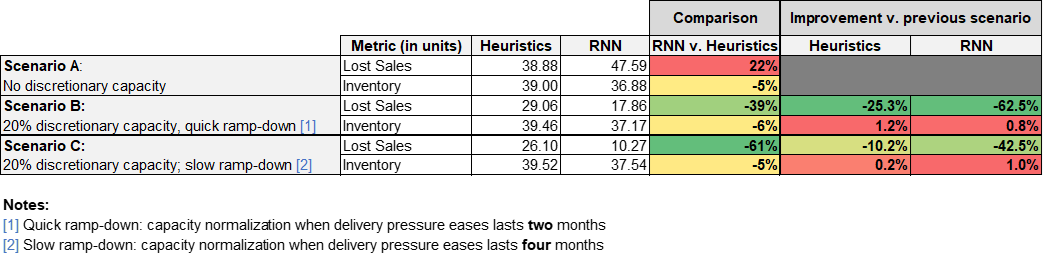